## Régression 
### Matrice de corrélation


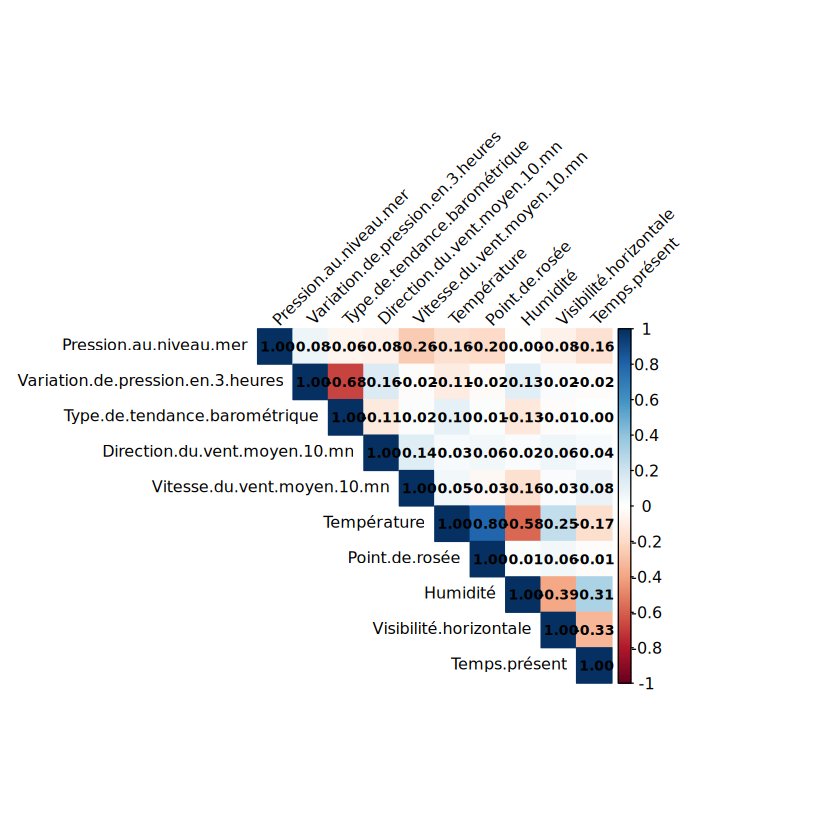

In [31]:
library(corrplot)
library(dplyr)
par(bg='white')
# Sélectionner uniquement les colonnes numériques
vars_num <- data_metropole %>% 
  select(where(is.numeric))

# Garder seulement les 10 premières colonnes numériques (optionnel)
vars_num <- vars_num[, 2:11]

# Corrélation
mat_cor <- cor(vars_num, use = "pairwise.complete.obs")

# Sauvegarde dans une grande image
# png("../fig/corrplot2.png", width = 1200, height = 1200, res = 150)

corrplot(mat_cor, method = "color", type = "upper",
         tl.col = "black", tl.srt = 45, 
         tl.cex = 0.8,         # taille du texte des labels
         addCoef.col = "black", 
         number.cex = 0.7)

# dev.off()


### Régression simple: moy_Humidté_mensuelle ~ moy_Température_mensuelle 

Afin de limiter les biais et de garantir une représentativité spatiale, nous avons sélectionné des stations météorologiques éloignées les unes des autres, réparties sur l’ensemble du territoire français :

* Nord : 7015 – Fretin (59, Hauts-de-France)
* Centre : 7149 – Athis-Mons (91, Essonne, Île-de-France)
* Ouest : 7110 – Guipavas (29, Finistère)
* Est : 7190 – Holtzheim (67, Bas-Rhin)
* Sud-Ouest : 7630 – Blagnac (31, Haute-Garonne). »

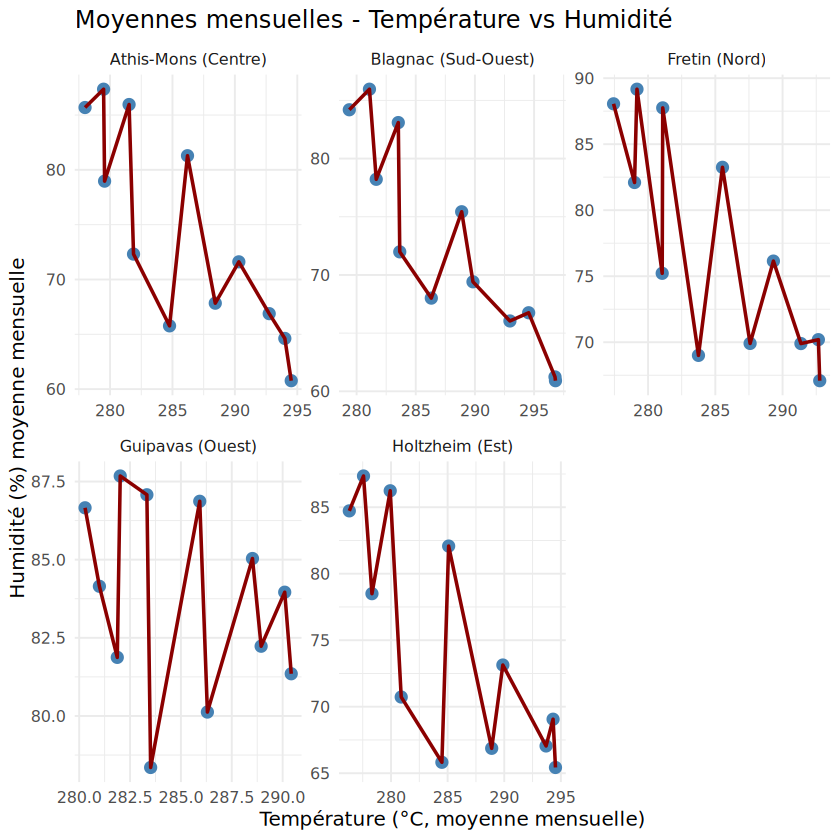

In [32]:
par(bg='white')
library(dplyr)
library(ggplot2)

stations_a_comparer <- c(7015, 7149, 7110, 7190, 7630)

# Dictionnaire ID → Nom
station_labels <- c(
  "7015" = "Fretin (Nord)",
  "7149" = "Athis-Mons (Centre)",
  "7110" = "Guipavas (Ouest)",
  "7190" = "Holtzheim (Est)",
  "7630" = "Blagnac (Sud-Ouest)"
)

# Calculer la moyenne mensuelle par station
data_monthly <- data_metropole %>%
  filter(ID.OMM.station %in% stations_a_comparer) %>%
  group_by(ID.OMM.station, mois_de_l_annee) %>%
  summarise(
    Température_moy = mean(Température, na.rm = TRUE),
    Humidité_moy = mean(Humidité, na.rm = TRUE),
    .groups = "drop"
  )

# Ajouter noms des stations
data_monthly <- data_monthly %>%
  mutate(Station = recode(as.character(ID.OMM.station), !!!station_labels))

# Plot
ggplot(data_monthly, aes(x = Température_moy, y = Humidité_moy)) +
  geom_point(color = "steelblue", size = 3) +
  geom_line(color = "darkred", size = 1) +
  theme_minimal(base_size = 12) +
  labs(title = "Moyennes mensuelles - Température vs Humidité",
       x = "Température (°C, moyenne mensuelle)",
       y = "Humidité (%) moyenne mensuelle") +
  facet_wrap(~ Station, scales = "free")



`geom_smooth()` using formula = 'y ~ x'


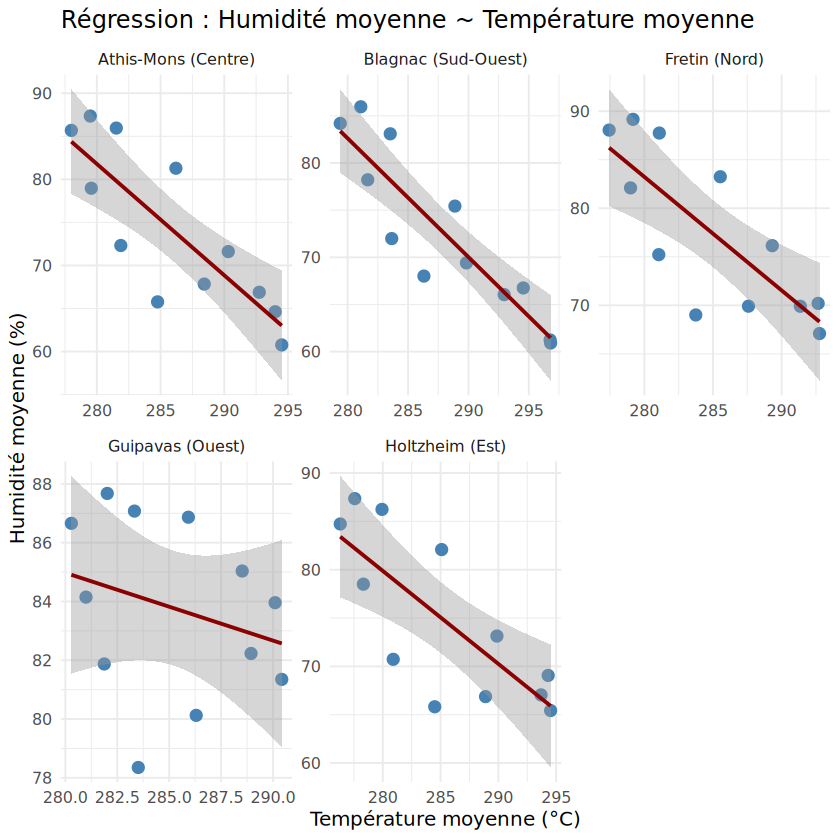

In [35]:
library(dplyr)
library(ggplot2)

stations_a_comparer <- c(7015, 7149, 7110, 7190, 7650, 7630)

# Dictionnaire ID → Nom de station
station_labels <- c(
  "7015" = "Fretin (Nord)",
  "7149" = "Athis-Mons (Centre)",
  "7110" = "Guipavas (Ouest)",
  "7190" = "Holtzheim (Est)",
  "7650" = "Marignane (Sud-Est)",
  "7630" = "Blagnac (Sud-Ouest)"
)

# 1. Calculer les moyennes mensuelles de Température et Humidité par station
data_monthly <- data_metropole %>%
  filter(ID.OMM.station %in% stations_a_comparer) %>%
  group_by(ID.OMM.station, mois_de_l_annee) %>%
  summarise(
    Temp_moy = mean(Température, na.rm = TRUE),
    Humid_moy = mean(Humidité, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  # Ajouter le nom des stations
  mutate(Station = recode(as.character(ID.OMM.station), !!!station_labels))

# 2. Plot avec régression linéaire par station
ggplot(data_monthly, aes(x = Temp_moy, y = Humid_moy)) +
  geom_point(color = "steelblue", size = 3) +
  geom_smooth(method = "lm", se = TRUE, color = "darkred") +
  theme_minimal(base_size = 12) +
  labs(title = "Régression : Humidité moyenne ~ Température moyenne",
       x = "Température moyenne (°C)",
       y = "Humidité moyenne (%)") +
  facet_wrap(~ Station, scales = "free")



Les régressions confirment une tendance physique attendue : hausse de la température ↔ baisse de l’humidité relative, avec une intensité différente selon les régions (plus forte en climat continental, plus atténuée en climat océanique).
Cependant, il faut rester prudent : l’usage de moyennes mensuelles, d’un modèle linéaire et l’absence de prise en compte de la saisonnalité limitent la portée explicative de ces résultats.

### Régression multiple:Visibilité_moy ~ Humidité + Température +Pression au niveau de la mer + Précipitations au 24h

L’objectif est de modéliser et d’expliquer la visibilité moyenne (Visibilité_moy) en fonction de plusieurs paramètres météorologiques. 
L’idée est de déterminer quels facteurs influencent le plus la visibilité et d’évaluer leur contribution relative. 

In [42]:
library(dplyr)

# ---- Préparation des données ----

# 1. Ajouter année et saison
data_metropole <- data_metropole %>%
  mutate(
    annee = format(as.Date(substr(Date, 1, 10)), "%Y"),
    saison = case_when(
      mois_de_l_annee %in% c(12, 1, 2)  ~ "Hiver",
      mois_de_l_annee %in% c(3, 4, 5)   ~ "Printemps",
      mois_de_l_annee %in% c(6, 7, 8)   ~ "Été",
      mois_de_l_annee %in% c(9, 10, 11) ~ "Automne"
    )
  )

# 2. Moyennes saisonnières par station et année
data_yearly <- data_metropole %>%
  group_by(ID.OMM.station, annee, saison) %>%
  summarise(
    Visib_moy   = mean(`Visibilité.horizontale`, na.rm = TRUE),
    Humid_moy   = mean(`Humidité`, na.rm = TRUE),
    Temp_moy    = mean(`Température`, na.rm = TRUE),
    Pression    = mean(`Pression.au.niveau.mer`, na.rm = TRUE),
    Precip_24h  = mean(`Précipitations.dans.les.24.dernières.heures`, na.rm = TRUE),
    .groups = "drop"
  )

# 3. Centrer et réduire les prédicteurs
data_yearly <- data_yearly %>%
  mutate(
    Humid_scaled    = scale(Humid_moy, center = TRUE, scale = TRUE)[,1],
    Temp_scaled     = scale(Temp_moy, center = TRUE, scale = TRUE)[,1],
    Pression_scaled = scale(Pression, center = TRUE, scale = TRUE)[,1],
    Precip_scaled   = scale(Precip_24h, center = TRUE, scale = TRUE)[,1]
  )


# A tibble: 20 × 6
   term            estimate std.error statistic   p.value Saison   
   <chr>              <dbl>     <dbl>     <dbl>     <dbl> <chr>    
 1 (Intercept)       27638.     1127.    24.5   7.79e- 82 Hiver    
 2 Humid_scaled      -6951.      580.   -12.0   1.82e- 28 Hiver    
 3 Temp_scaled         336.      914.     0.368 7.13e-  1 Hiver    
 4 Pression_scaled    -112.      371.    -0.302 7.63e-  1 Hiver    
 5 Precip_scaled      -216.      460.    -0.471 6.38e-  1 Hiver    
 6 (Intercept)       25130.      740.    34.0   6.58e-115 Printemps
 7 Humid_scaled      -4892.      641.    -7.63  2.13e- 13 Printemps
 8 Temp_scaled        7603.     1411.     5.39  1.27e-  7 Printemps
 9 Pression_scaled   -1083.      545.    -1.99  4.76e-  2 Printemps
10 Precip_scaled      1938.      636.     3.04  2.50e-  3 Printemps
11 (Intercept)       15684.     1730.     9.07  5.52e- 18 Été      
12 Humid_scaled      -2289.      663.    -3.45  6.13e-  4 Été      
13 Temp_scaled        8049.  

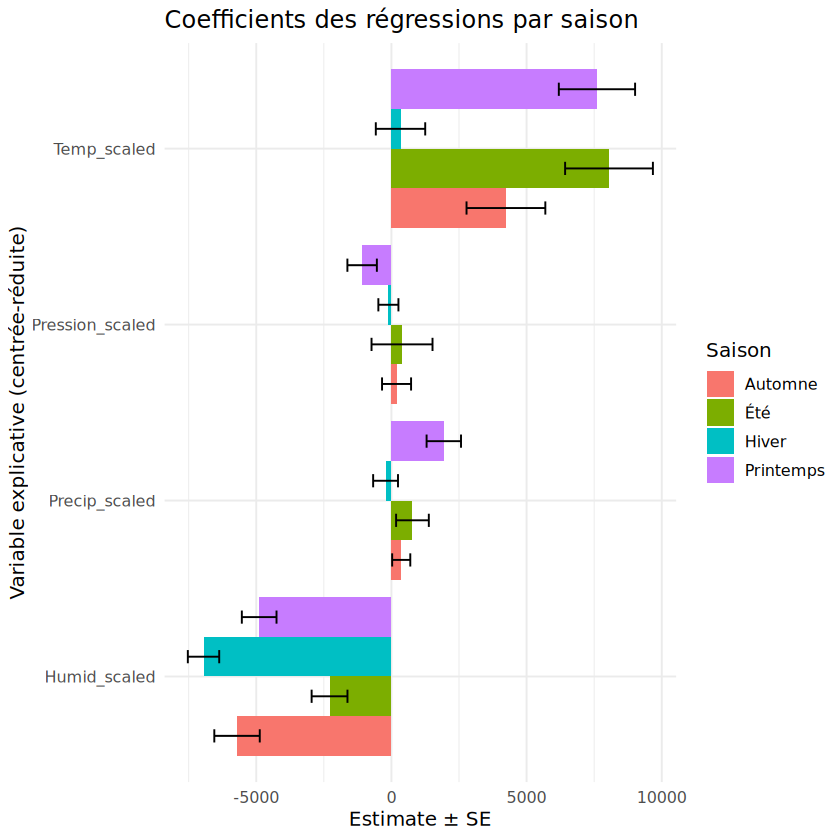

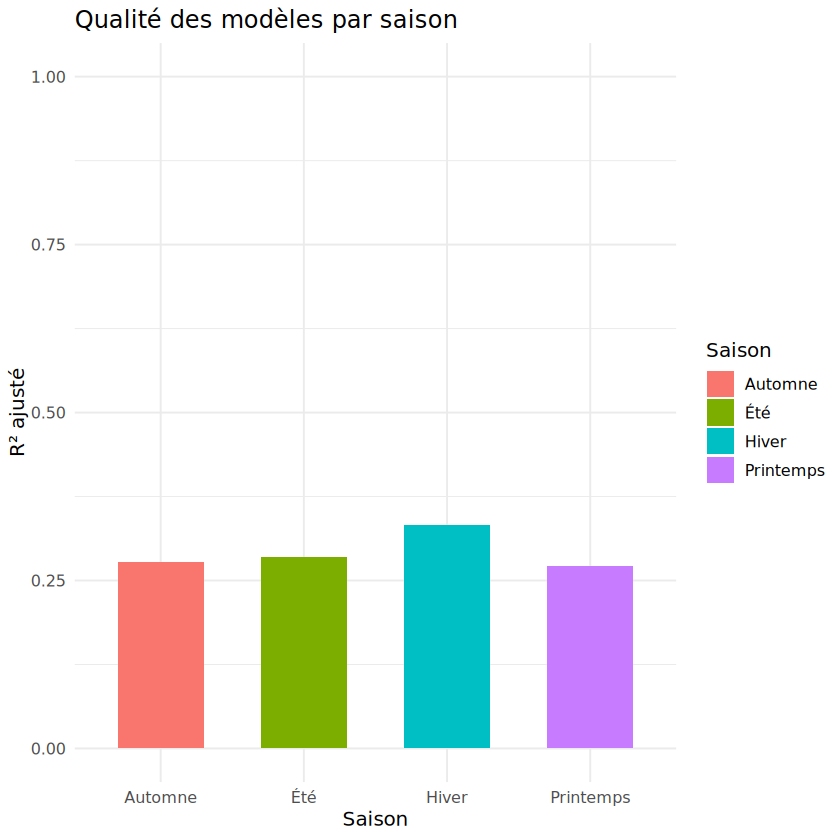

In [43]:
library(dplyr)
library(broom)   # pour tidy() et glance()

# 1. Fonction qui ajuste et retourne les résultats
fit_model <- function(saison_name) {
  d <- filter(data_yearly, saison == saison_name)
  modele <- lm(Visib_moy ~ Humid_scaled + Temp_scaled + Pression_scaled + Precip_scaled,
               data = d)
  tidy_res   <- broom::tidy(modele) %>% mutate(Saison = saison_name)
  glance_res <- broom::glance(modele) %>% mutate(Saison = saison_name)
  list(tidy = tidy_res, glance = glance_res)
}

# 2. Ajuster les 4 modèles
res_hiver     <- fit_model("Hiver")
res_printemps <- fit_model("Printemps")
res_ete       <- fit_model("Été")
res_automne   <- fit_model("Automne")

# 3. Rassembler les coefficients
coef_all <- bind_rows(res_hiver$tidy, res_printemps$tidy, 
                      res_ete$tidy, res_automne$tidy)

# 4. Rassembler les métriques globales (R², AIC, etc.)
stats_all <- bind_rows(res_hiver$glance, res_printemps$glance,
                       res_ete$glance, res_automne$glance)

# 👉 Afficher
print(coef_all)   # détails des coefficients par saison
print(stats_all)  # qualité globale par saison
library(ggplot2)

# ---- 1. Plot des coefficients par saison ----
ggplot(coef_all %>% filter(term != "(Intercept)"),
       aes(x = term, y = estimate, fill = Saison)) +
  geom_col(position = "dodge") +
  geom_errorbar(aes(ymin = estimate - std.error,
                    ymax = estimate + std.error),
                position = position_dodge(width = 0.9), width = 0.3) +
  theme_minimal(base_size = 12) +
  labs(title = "Coefficients des régressions par saison",
       x = "Variable explicative (centrée-réduite)",
       y = "Estimate ± SE") +
  coord_flip()

# ---- 2. Plot des R² ajustés par saison ----
ggplot(stats_all, aes(x = Saison, y = adj.r.squared, fill = Saison)) +
  geom_col(width = 0.6) +
  theme_minimal(base_size = 12) +
  labs(title = "Qualité des modèles par saison",
       x = "Saison",
       y = "R² ajusté") +
  ylim(0, 1)


La première figure montre l’effet des variables météo sur la visibilité selon la saison.

* **Humidité** : impact négatif net, surtout en hiver et automne (brouillard, air saturé).
* **Température** : effet positif marqué au printemps et en été (air plus sec, meilleure visibilité).
* **Pression et précipitations** : effets faibles ou non significatifs.

Globalement, la visibilité est surtout conditionnée par l’humidité (réduction) et la température (amélioration).

La deuxième figure montre la qualité des modèles par saison via le R² ajusté.

Commentaire concis :

Les modèles expliquent environ 25 à 35 % de la variabilité de la visibilité, avec des performances légèrement meilleures en hiver. Cela indique que les variables météo incluses (température, humidité, pression, précipitations) capturent une partie de l’effet, mais qu’une grande part de la variabilité reste inexpliquée.

Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 11 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 12 rows containing missing values or values outside the scale range
(`geom_point()`).”


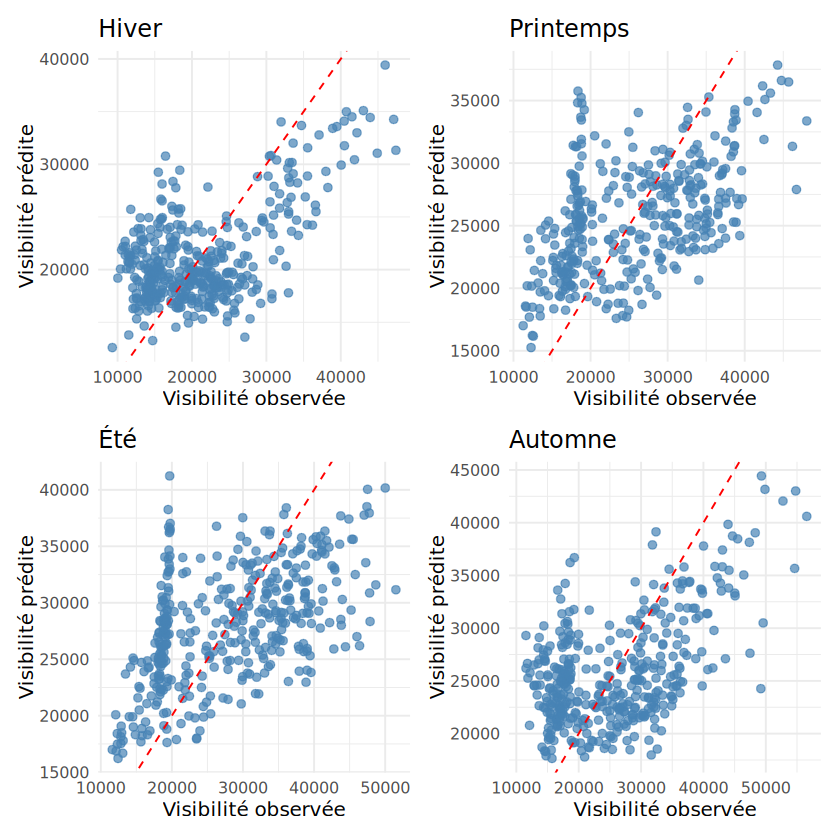

In [ ]:
# ---- Fonction pour ajuster un modèle et créer un plot ----
fit_plot <- function(saison_name) {
  d <- filter(data_yearly, saison == saison_name)
  
  # Ajuster la régression
  modele <- lm(Visib_moy ~ Humid_scaled + Temp_scaled + Pression_scaled + Precip_scaled,
               data = d)
  
  # Ajouter les prédictions
  d$Pred <- predict(modele, newdata = d)
  
  # Scatter plot Observé vs Prédit
  ggplot(d, aes(x = Visib_moy, y = Pred)) +
    geom_point(color = "steelblue", size = 2, alpha = 0.7) +
    geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
    theme_minimal(base_size = 12) +
    labs(
      title = saison_name,
      x = "Visibilité observée",
      y = "Visibilité prédite"
    )
}

# ---- Générer les 4 plots ----
plot_hiver     <- fit_plot("Hiver")
plot_printemps <- fit_plot("Printemps")
plot_ete       <- fit_plot("Été")
plot_automne   <- fit_plot("Automne")

# ---- Afficher en grille 2x2 ----
(plot_hiver | plot_printemps) / (plot_ete | plot_automne)


ces graphiques montrent que les modèles expliquent correctement la tendance générale de la visibilité,
surtout en hiver, mais restent imparfaits, avec une tendance à sous-estimer les fortes visibilités 
et une dispersion notable dans les autres saisons.